In [2]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

import scipy
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np
import tensorflow as tf
from dsn.train_dsn import train_dsn
from dsn.util.systems import V1Circuit
from dsn.util.dsn_util import get_savedir, \
                              get_system_from_template, \
                              get_arch_from_template, \
                              get_ME_model
from dsn.util.plot_util import assess_constraints_mix, plot_opt, dsn_pairplots, \
                               pairplot, lin_reg_plot
from tf_util.stat_util import approx_equal
import matplotlib.backends.backend_pdf
from sklearn import linear_model
from dsn.util.plot_util import PCA

import os

os.chdir('../../')

ISN_coeff
0 models/V1Circuit_0-20/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=1R_8M_2L_10U_M_A_c=2_rs=1/
1 models/V1Circuit_0-20/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=1R_8M_2L_10U_M_A_c=2_rs=2/
2 models/V1Circuit_0-20/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=1R_8M_2L_10U_M_A_c=2_rs=3/
3 models/V1Circuit_0-20/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_V=0_flow=1R_8M_2L_10U_M_A_c=2_rs=4/


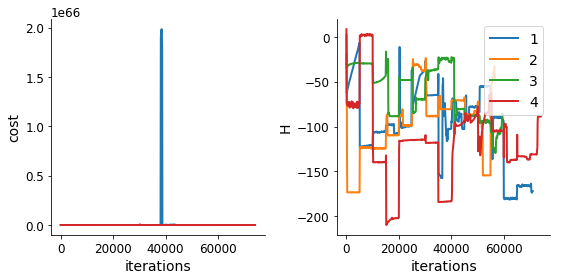

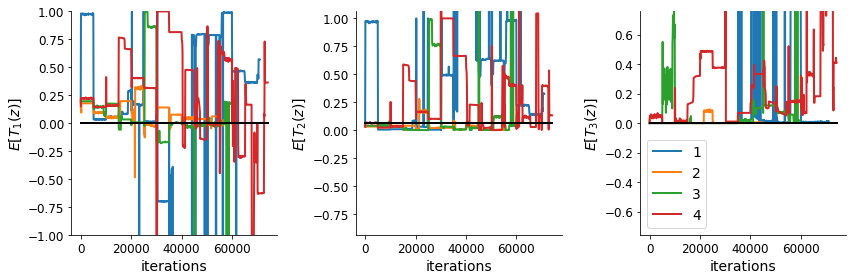

In [4]:
sysname = "V1Circuit"
silenced_pops = ['V']
dirstr = 'V1Circuit_0-20'

behavior_type = "ISN_coeff"
repeats = 1
nlayers = 2
upl = 10

best_models = []
ME_its = []

# multivariate normal initialization variance
c_init_order = 2
sigma_init = np.ones((8,))
start_rs = 1
num_rs = 4

alpha=0.05
frac_samps=0.05
tol = 0.02*np.ones((1,))
tol_inds = [2]

conv_dict = {
    'alpha':alpha,
    'frac_samples':frac_samps,
    'tol':tol,
    'tol_inds':tol_inds
}

for silenced in silenced_pops:
    param_dict = {'behavior_type':behavior_type,
                  'silenced':silenced}
    system = get_system_from_template(sysname, param_dict)
    
    arch_params = {
                   'D':system.D,
                   'repeats':repeats,
                   'nlayers':nlayers,
                   'upl':upl
                  }
    param_dict.update(arch_params)
    arch_dict = get_arch_from_template(sysname, param_dict)
    
    model_dirs = []
    for rs in range(start_rs, start_rs+num_rs):
        model_dirs.append(get_savedir(system, arch_dict, sigma_init, c_init_order, rs, dirstr))
    legendstrs = np.arange(start_rs, start_rs+num_rs)
    figs, ME_its = plot_opt(model_dirs, legendstrs=legendstrs, con_method='mix',
                            alpha=alpha, frac_samps=frac_samps, \
                            tol=tol, tol_inds=tol_inds, \
                            maxconlim=1.0)

In [5]:
print(ME_its)

[None, array(9), None, None]


0
 has not converged so not plotting.
1
dist (1000, 8)
T_x1
2
 has not converged so not plotting.
3
 has not converged so not plotting.


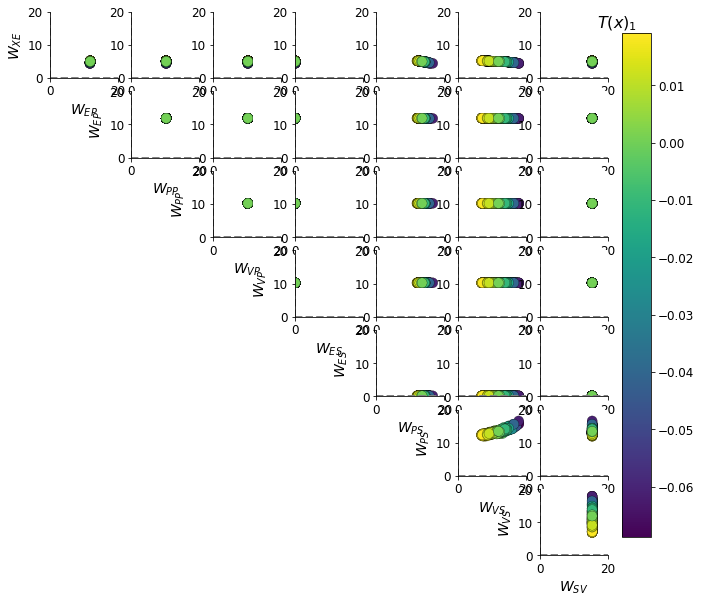

In [6]:
dists, cs, axs = dsn_pairplots(model_dirs, 'Zs', system, system.D, 
                               c_str='T_x1', AL_final_its=ME_its,
                               xlims=[0, 20], ylims=[0, 20])

0
dist (1000, 3)
log_q_z


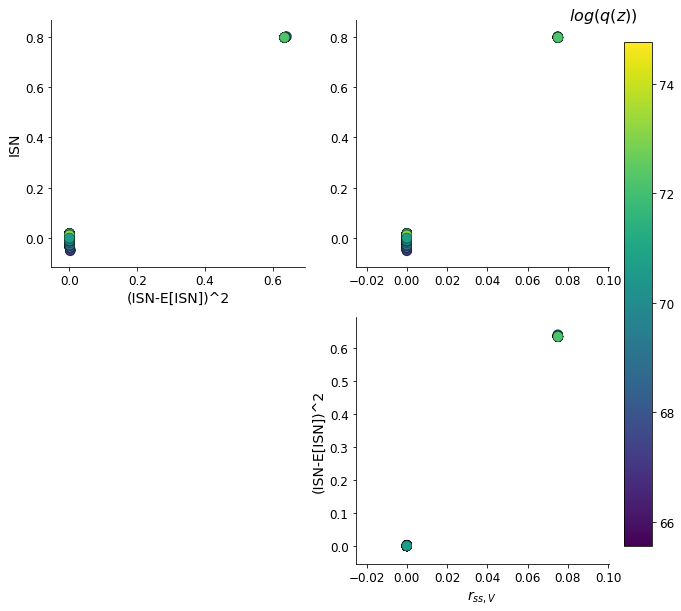

In [19]:
dists, cs, axs = dsn_pairplots(model_dirs, 'T_xs', system, system.num_suff_stats, 
                               c_str='log_q_z', AL_final_its=ME_its)


In [6]:
print(np.sum(dists[0][:,2] > 0.02))

1


In [7]:
from tf_util.tf_util import load_dgm, init_batch_norms

M = 1000
_W = np.random.normal(0.0, 1.0, (1, M, 8))

ind = 0
model_dir = model_dirs[ind]
ME_it = ME_its[ind]

sess = tf.Session()
collection = load_dgm(sess, model_dir, ME_it)
W, Z, log_q_Z, Z_INV, batch_norm_mus, batch_norm_sigmas, batch_norm_layer_means, batch_norm_layer_vars = collection
   
num_batch_norms = len(batch_norm_mus)

param_fname = model_dir + 'params.npz'
paramfile = np.load(param_fname)
_batch_norm_mus = paramfile['batch_norm_mus'][ME_it]
_batch_norm_sigmas = paramfile['batch_norm_sigmas'][ME_it]

feed_dict = {W:_W}

for j in range(num_batch_norms):
    feed_dict.update({batch_norm_mus[j]:_batch_norm_mus[j]})
    feed_dict.update({batch_norm_sigmas[j]:_batch_norm_sigmas[j]})

Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from models/V1Circuit_0-20/V1Circuit_D=8_ISN_0.00E+00_2.50E-01_S=0_flow=1R_8M_2L_15U_M_A_c=2_rs=4/model-11


In [8]:

_Z_INV, _Z, _log_q_z = sess.run([Z_INV, Z, log_q_Z], feed_dict)


In [27]:
param_fname = model_dir + 'params.npz'
x = np.load(param_fname)
print(x['batch_norm_mus'][4])

[[0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0.]]


In [35]:


from tf_util.tf_util import dgm_hessian
H = dgm_hessian(log_q_Z, W, Z, Z_INV)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [36]:
w_max = np.zeros((1,1,8))
feed_dict.update({W:w_max})
_H = sess.run(H, feed_dict)
print(_H)

[[-5.40389816e+03 -2.55767117e+03 -4.92171823e+01  1.03193307e+05
  -2.73232036e+04  5.50962766e+03 -1.97965105e+03  2.57876860e+02]
 [-2.55767117e+03 -1.21429568e+03 -2.31147990e+01  4.89912202e+04
  -1.29727963e+04  2.61607130e+03 -9.40285881e+02  1.22889526e+02]
 [-4.92171823e+01 -2.31147990e+01 -1.28317070e+01  9.28885234e+02
  -2.43767252e+02  5.06104765e+01 -1.90754903e+01  2.08645777e+00]
 [ 1.03193307e+05  4.89912202e+04  9.28885234e+02 -1.97646484e+06
   5.23331529e+05 -1.05545006e+05  3.79229150e+04 -4.95098747e+03]
 [-2.73232036e+04 -1.29727963e+04 -2.43767252e+02  5.23331529e+05
  -1.38573480e+05  2.79442785e+04 -1.00392130e+04  1.31025345e+03]
 [ 5.50962766e+03  2.61607130e+03  5.06104765e+01 -1.05545006e+05
   2.79442785e+04 -5.62845492e+03  2.02050321e+03 -2.66138022e+02]
 [-1.97965105e+03 -9.40285881e+02 -1.90754903e+01  3.79229150e+04
  -1.00392130e+04  2.02050321e+03 -7.26271178e+02  9.57345329e+01]
 [ 2.57876860e+02  1.22889526e+02  2.08645777e+00 -4.95098747e+03
   

In [13]:

d, v = np.linalg.eig(_H)
print('d', d)

d [-0.29614217 -1.37255948 -1.38068038 -1.13279738 -1.18681943 -0.60701439
 -0.69906753 -0.76993936]
